In [1]:
from time import perf_counter

import numpy as np
from scipy.stats import mode
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

The K-Nearest Neighbors (KNN) algorithm is a simple, versatile machine learning algorithm used for both classification and regression tasks. Here's a high-level explanation of how it works, along with algorithmic steps:

1. Data preparation:
   - Have a dataset with labeled examples
   - Choose a value for K (the number of nearest neighbors to consider)

2. For a new data point to be classified or have its value predicted:

   a. Calculate the distance between the new point and all points in the dataset
      - Common distance metrics: Euclidean distance, Manhattan distance, or Hamming distance

   b. Sort the distances in ascending order

   c. Select the K points with the smallest distances to the new point

   d. For classification:
      - Count the frequency of each class among the K neighbors
      - Assign the most frequent class to the new point

      For regression:
      - Calculate the average (or weighted average) of the target values of the K neighbors
      - Assign this average as the predicted value for the new point

3. Return the predicted class or value for the new data point

Key considerations:
- Choice of K: Smaller K can lead to overfitting, larger K to smoother decision boundaries
- Distance metric: Choose based on the nature of your data
- Scaling: Normalize or standardize features if they're on different scales
- Dimensionality: KNN can struggle with high-dimensional data (curse of dimensionality)

This algorithm is intuitive and doesn't require a separate training phase, but it can be computationally expensive for large datasets.

In [2]:
num_samples = 1000
num_features = 1000
num_informative = min(num_features, 100)
X, y = make_classification(
    n_samples=num_samples,
    n_classes=4,
    n_features=num_features,
    n_informative=num_informative,
    n_redundant=num_features-num_informative,
    n_repeated=0,
    n_clusters_per_class=1,
    weights=[0.7, 0.12, 0.15, 0.03],
    random_state=2024,
    hypercube=False,
)

In [3]:
# number of nearest neighbors
K = 20

## Approach 1: Brute force $O(n^2)$

In [4]:
start = perf_counter()
norms_v1 = np.zeros((num_samples, num_samples), dtype=np.float32)
for i in range(num_samples):
    # calculate distances only for upper triangular matrix
    for j in range(i, num_samples):
        diff = X[i] - X[j]
        norms_v1[i, j] = np.linalg.norm(diff)

# calculate pairwise distances
pairwise_distances_v1 = norms_v1 + norms_v1.T

# get the indices that sort the pairwise distances
sorted_distances_indices_v1 = np.argsort(pairwise_distances_v1, axis=1)
print(f'Time taken: {(perf_counter() - start):.4f} seconds')
# norms

Time taken: 0.8772 seconds


## Approach 2: No `for` loops (NumPy vectorization)

In [5]:
start = perf_counter()
# change the shapes to allow for broadcasting
diff = X[:, None, :] - X[None]

# pairwise distances
pairwise_distances_v2 = np.linalg.norm(diff, axis=-1, keepdims=True).squeeze()

# indices that sort the distances
sorted_distances_indices_v2 = np.argsort(pairwise_distances_v2, axis=1)
print(f'Time taken: {(perf_counter() - start):.4f} seconds')

Time taken: 32.0112 seconds


## Classification

In [6]:
# randomly select some points
samples = np.random.choice(len(X), size=50, replace=False)

# find the sorted distances of the neighbors of the sampled points
neighbor_distances_indices = sorted_distances_indices_v2[samples][:, : K + 1]

# get the class information of all the neighbors
# first column is the sample itself since its pairwise distance with itself is obviously zero
neighbor_classes = y[neighbor_distances_indices[:, 1:]]

# get the most frequent class as the predictions
predictions = mode(neighbor_classes, axis=1)[0]

# ground truth of the samples
true_class = y[neighbor_distances_indices[:, 0]]

# calculate accuracy
accuracy = (sum(predictions == true_class) / len(true_class)).item()
print(f"Accuracy: {(accuracy * 100):.2f}%")

Accuracy: 74.00%


In [7]:
print(classification_report(y_true=true_class, y_pred=predictions))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        35
           1       0.00      0.00      0.00         4
           2       1.00      0.25      0.40         8
           3       0.00      0.00      0.00         3

    accuracy                           0.74        50
   macro avg       0.43      0.31      0.31        50
weighted avg       0.67      0.74      0.65        50



/Users/lakshya/micromamba/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lakshya/micromamba/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lakshya/micromamba/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

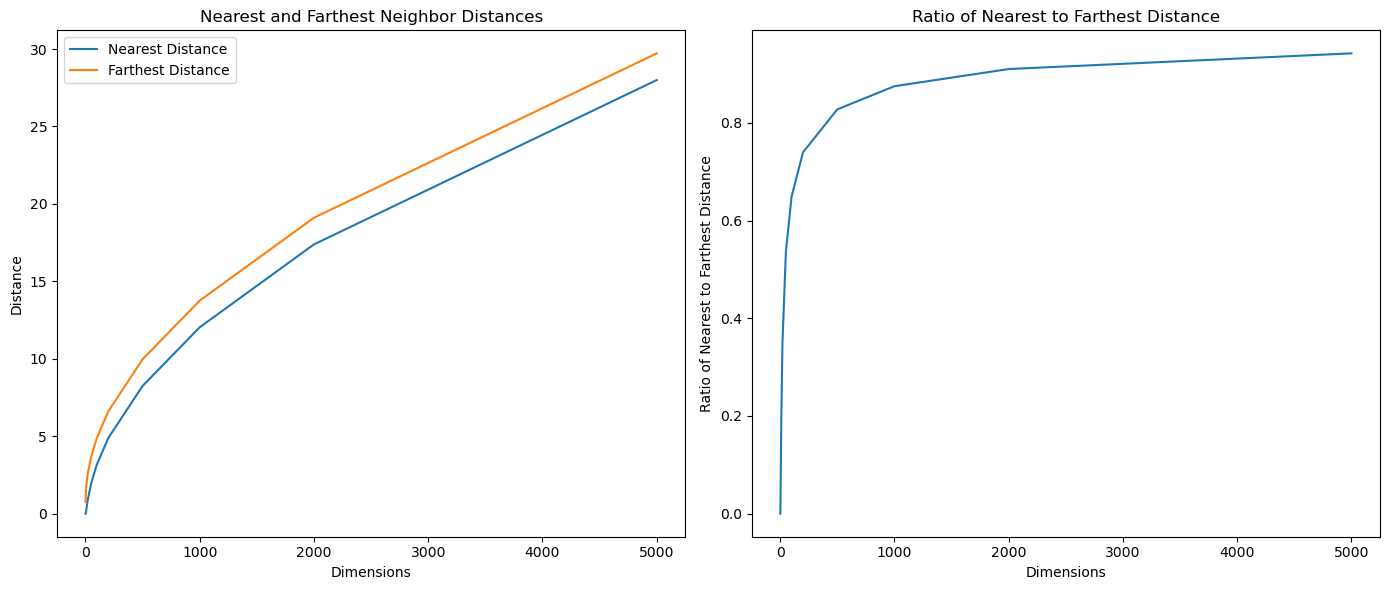

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Generate synthetic data
def generate_data(samples, dimensions):
    return np.random.rand(samples, dimensions)

# Analyze distances
def analyze_distances(data):
    distances = pairwise_distances(data, metric='euclidean')
    nearest_distances = np.min(distances + np.eye(distances.shape[0]) * np.max(distances), axis=1)
    farthest_distances = np.max(distances, axis=1)
    ratio = nearest_distances / farthest_distances
    return nearest_distances, farthest_distances, ratio

# Plotting function
def plot_analysis(dimensions, nearest_distances, farthest_distances, ratios):
    plt.figure(figsize=(14, 6))

    # Plot distances
    plt.subplot(1, 2, 1)
    plt.plot(dimensions, nearest_distances, label='Nearest Distance')
    plt.plot(dimensions, farthest_distances, label='Farthest Distance')
    plt.xlabel('Dimensions')
    plt.ylabel('Distance')
    plt.title('Nearest and Farthest Neighbor Distances')
    plt.legend()

    # Plot ratio of distances
    plt.subplot(1, 2, 2)
    plt.plot(dimensions, ratios)
    plt.xlabel('Dimensions')
    plt.ylabel('Ratio of Nearest to Farthest Distance')
    plt.title('Ratio of Nearest to Farthest Distance')

    plt.tight_layout()
    plt.show()

# Experiment setup
samples = 10000  # Number of samples
dimension_list = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]  # Different dimensions

nearest_distances_list = []
farthest_distances_list = []
ratios_list = []

# Run the analysis for each dimension
for dim in dimension_list:
    data = generate_data(samples, dim)
    nearest, farthest, ratio = analyze_distances(data)
    nearest_distances_list.append(np.mean(nearest))
    farthest_distances_list.append(np.mean(farthest))
    ratios_list.append(np.mean(ratio))

# Plot the results
plot_analysis(dimension_list, nearest_distances_list, farthest_distances_list, ratios_list)
